In [17]:
#Step-1: Imports and Device setup
import os
from pathlib import Path
from time import time 
from typing import Tuple, Dict

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import xarray as xr
import xesmf as xe

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
#Step-2: Load and preprocess data

file_path = Path("output-tracer-release_2025-02-16.nc")
ds = xr.open_dataset(file_path)

# Extract and align variables on (time, y, x)
u = ds['u'].squeeze('zC').rename({'xF': 'x', 'yC': 'y'})     # shape: (time, y, x)
v = ds['v'].squeeze('zC').rename({'xC': 'x', 'yF': 'y'})     # shape: (time, y, x)
c = ds['c'].squeeze('zC').rename({'xC': 'x', 'yC': 'y'})     # shape: (time, y, x)

# Merge into single xarray.Dataset and fill NaNs
ds_merge = xr.merge([u.to_dataset(name='u'),
                     v.to_dataset(name='v'),
                     c.to_dataset(name='c')])
ds_merge = ds_merge.fillna(0.0)  # Simple zero-fill — safe to start with


# Split into input and output time steps (t -> t+1)
ds_input = ds_merge.isel(time=slice(0, -1))   # t0 ... t_{n-2}: Input at t
ds_target = ds_merge.isel(time=slice(1, None))  # t1 ... t_{n-1}: Output at t+1


In [3]:
x = ds["xC"].values  # shape: (Nx,)
y = ds["yC"].values  # shape: (Ny,)

dx = float(x[1] - x[0])  # spacing in meters
dy = float(y[1] - y[0])  # spacing in meters

dy

1000.0

In [4]:
ds

<xarray.Dataset>
Dimensions:  (zC: 1, zF: 1, xC: 100, yF: 100, xF: 100, yC: 100, time: 2401)
Coordinates:
  * zC       (zC) float32 -5.0
  * zF       (zF) float32 -10.0
  * xC       (xC) float32 500.0 1.5e+03 2.5e+03 ... 9.75e+04 9.85e+04 9.95e+04
  * yF       (yF) float32 0.0 1e+03 2e+03 3e+03 ... 9.7e+04 9.8e+04 9.9e+04
  * xF       (xF) float32 0.0 1e+03 2e+03 3e+03 ... 9.7e+04 9.8e+04 9.9e+04
  * yC       (yC) float32 500.0 1.5e+03 2.5e+03 ... 9.75e+04 9.85e+04 9.95e+04
  * time     (time) timedelta64[ns] 00:00:00 01:00:00 ... 100 days 00:00:00
Data variables:
    v        (time, zC, yF, xC) float32 ...
    S        (time, zC, yC, xC) float32 ...
    c        (time, zC, yC, xC) float32 ...
    T        (time, zC, yC, xC) float32 ...
    u        (time, zC, yC, xF) float32 ...
Attributes:
    time averaging stride:  Output was time averaged with a stride of 1 itera...
    interval:               3600.0
    time_averaging_window:  3600.0
    time_averaging_stride:  1
    Oceananigans:           This file was generated using 
    Julia:                  This file was generated using Julia Version 1.11....
    output time interval:   Output was saved every 1 hour.
    date:                   This file was generated on 2025-02-16T21:11:32.835.
    time averaging window:  Output was time averaged with a window size of 1 ...
    schedule:               TimeInterval

In [5]:
print(ds['u'].isel(time=0).values)  # or .isel(time=0).plot() for a quick look
print(np.isnan(ds['u']).sum())


[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
<xarray.DataArray 'u' ()>
array(0)


In [6]:
#Step-3: Convert to PyTorch tensors

def to_tensor(ds, var_list):
    arr = ds[var_list].to_array().values  # shape: (vars, time, y, x)
    return torch.tensor(arr, dtype=torch.float32).permute(1, 0, 2, 3).to(device)  # (time, vars, y, x)

forcing_vars = ['u', 'v']
prognostic_vars = ['c']
input_vars = forcing_vars + prognostic_vars
output_vars = prognostic_vars

forcing_tensor = to_tensor(ds_input, forcing_vars)
prognostic_tensor = to_tensor(ds_input, prognostic_vars)
target_tensor = to_tensor(ds_target, output_vars)

print("Forcing shape:", forcing_tensor.shape)
print("Prognostic shape:", prognostic_tensor.shape)
print("Target shape:", target_tensor.shape)


Forcing shape: torch.Size([2400, 2, 200, 200])
Prognostic shape: torch.Size([2400, 1, 200, 200])
Target shape: torch.Size([2400, 1, 200, 200])


In [7]:
# Normalize each tensor independently

def normalize(tensor):
    mean = tensor.mean()
    std = tensor.std()
    return (tensor - mean) / std, mean, std

forcing_tensor, f_mean, f_std = normalize(forcing_tensor)
prognostic_tensor, p_mean, p_std = normalize(prognostic_tensor)
target_tensor = (target_tensor - p_mean) / p_std  # Normalize same as prognostic

In [8]:
# Sanity check
print("NaNs in forcing:", torch.isnan(forcing_tensor).sum().item())
print("NaNs in target:", torch.isnan(target_tensor).sum().item())
print("Preprocessed tensor shapes:", forcing_tensor.shape, prognostic_tensor.shape, target_tensor.shape)

NaNs in forcing: 0
NaNs in target: 0
Preprocessed tensor shapes: torch.Size([2400, 2, 200, 200]) torch.Size([2400, 1, 200, 200]) torch.Size([2400, 1, 200, 200])


In [9]:
def compute_physics_loss(forcing, prognostic, model_output, dx, dy, D=0.0):
    """
    Computes PDE residual from advection-diffusion equation.
    All inputs are (batch, 1, H, W)
    """
    u = forcing[:, 0]
    v = forcing[:, 1]
    c_t = prognostic[:, 0]
    c_tp1 = model_output[:, 0]

    dt = 1.0  # time step in hours; can change if needed
    dc_dt = (c_tp1 - c_t) / dt

    dc_dx = (torch.roll(c_t, -1, dims=2) - torch.roll(c_t, 1, dims=2)) / (2 * dx)
    dc_dy = (torch.roll(c_t, -1, dims=1) - torch.roll(c_t, 1, dims=1)) / (2 * dy)

    advection = u * dc_dx + v * dc_dy

    if D > 0:
        d2c_dx2 = (torch.roll(c_t, -1, 2) - 2 * c_t + torch.roll(c_t, 1, 2)) / dx**2
        d2c_dy2 = (torch.roll(c_t, -1, 1) - 2 * c_t + torch.roll(c_t, 1, 1)) / dy**2
        diffusion = D * (d2c_dx2 + d2c_dy2)
    else:
        diffusion = 0.0

    residual = dc_dt + advection - diffusion
    return torch.mean(residual**2)


In [10]:
#Step-4: Define the PINN Model
class ConvPINN(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(n_inputs, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, n_outputs, kernel_size=3, padding=1)
        )

    def forward(self, forcing, prognostic, training=True, num_future_steps=1):
        if training:
            x = torch.cat([forcing, prognostic], dim=1)  # shape: [B, 3, H, W]
            return self.model(x)
        else:
            predictions = []
            current_state = prognostic

            for t in range(num_future_steps):
                x = torch.cat([forcing[t:t+1], current_state], dim=1)
                current_state = self.model(x)
                predictions.append(current_state)

            return torch.cat(predictions, dim=0)  # shape: [T, 1, H, W]


In [13]:
#Step-5: Training Loop

# Hyperparameters
epochs = 5
batch_size = 8
learning_rate = 1e-4
physics_weight = 1.0

# Initialize model, optimizer, and loss function
model = ConvPINN(n_inputs=3, n_outputs=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# Total time steps available
num_steps = forcing_tensor.shape[0]

# Loss history
loss_total_history = []
loss_data_history = []
loss_phys_history = []


for epoch in range(epochs):
    model.train()
    epoch_loss_data = 0.0
    epoch_loss_phys = 0.0
    count = 0

    for i in range(0, num_steps - batch_size, batch_size):
        f_batch = forcing_tensor[i:i+batch_size]
        p_batch = prognostic_tensor[i:i+batch_size]
        t_batch = target_tensor[i:i+batch_size]

        optimizer.zero_grad()
        pred = model(f_batch, p_batch, training=True)

        loss_data = loss_fn(pred, t_batch)
        loss_phys = compute_physics_loss(
            f_batch, p_batch, pred,
            dx=1000.0, dy=1000.0,
            D=2e-9
        )

        loss = loss_data + physics_weight * loss_phys
        loss.backward()
        optimizer.step()

        epoch_loss_data += loss_data.item()
        epoch_loss_phys += loss_phys.item()
        count += 1

    avg_loss_data = epoch_loss_data / count
    avg_loss_phys = epoch_loss_phys / count
    avg_loss_total = avg_loss_data + physics_weight * avg_loss_phys

    loss_data_history.append(avg_loss_data)
    loss_phys_history.append(avg_loss_phys)
    loss_total_history.append(avg_loss_total)

    print(f"Epoch {epoch+1}/{epochs} — Avg Data Loss: {avg_loss_data:.6f} | Avg Phys Loss: {avg_loss_phys:.6f} | Total: {avg_loss_total:.6f}")

Epoch 1/5 — Avg Data Loss: 0.634480 | Avg Phys Loss: 0.704837 | Total: 1.339317
Epoch 2/5 — Avg Data Loss: 0.198743 | Avg Phys Loss: 0.173255 | Total: 0.371999
Epoch 3/5 — Avg Data Loss: 0.159883 | Avg Phys Loss: 0.119266 | Total: 0.279149
Epoch 4/5 — Avg Data Loss: 0.134648 | Avg Phys Loss: 0.084047 | Total: 0.218695
Epoch 5/5 — Avg Data Loss: 0.117484 | Avg Phys Loss: 0.056868 | Total: 0.174352


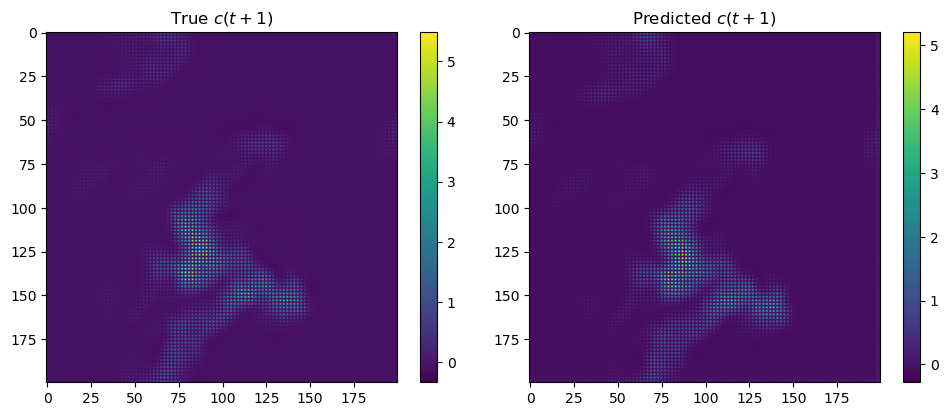

In [14]:
#Step-6: Evaluation Example 

model.eval()

# Pick a time step to test
i = 2000
f_test = forcing_tensor[i:i+1]
p_test = prognostic_tensor[i:i+1]
t_true = target_tensor[i:i+1]

with torch.no_grad():
    pred = model(f_test, p_test, training=True)

# Plot true vs predicted
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("True $c(t+1)$")
plt.imshow(t_true.squeeze().cpu(), cmap='viridis')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Predicted $c(t+1)$")
plt.imshow(pred.squeeze().cpu(), cmap='viridis')
plt.colorbar()

plt.tight_layout()
plt.show()

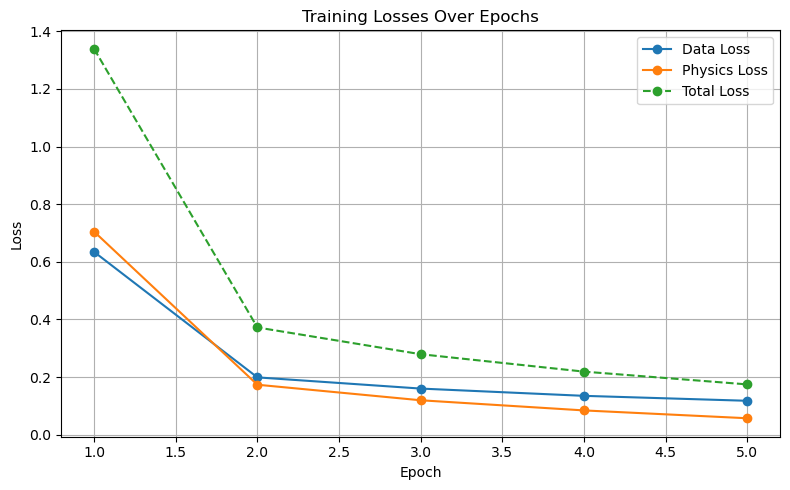

In [15]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, loss_data_history, label="Data Loss", marker='o')
plt.plot(epochs_range, loss_phys_history, label="Physics Loss", marker='o')
plt.plot(epochs_range, loss_total_history, label="Total Loss", marker='o', linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("training_losses.png")
plt.show()

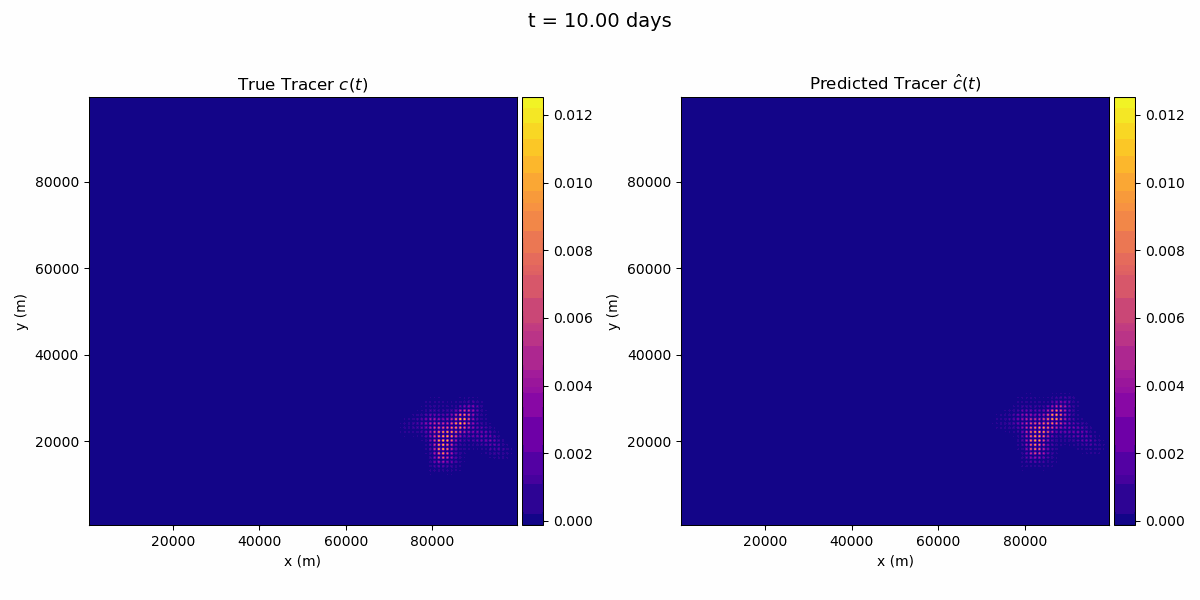

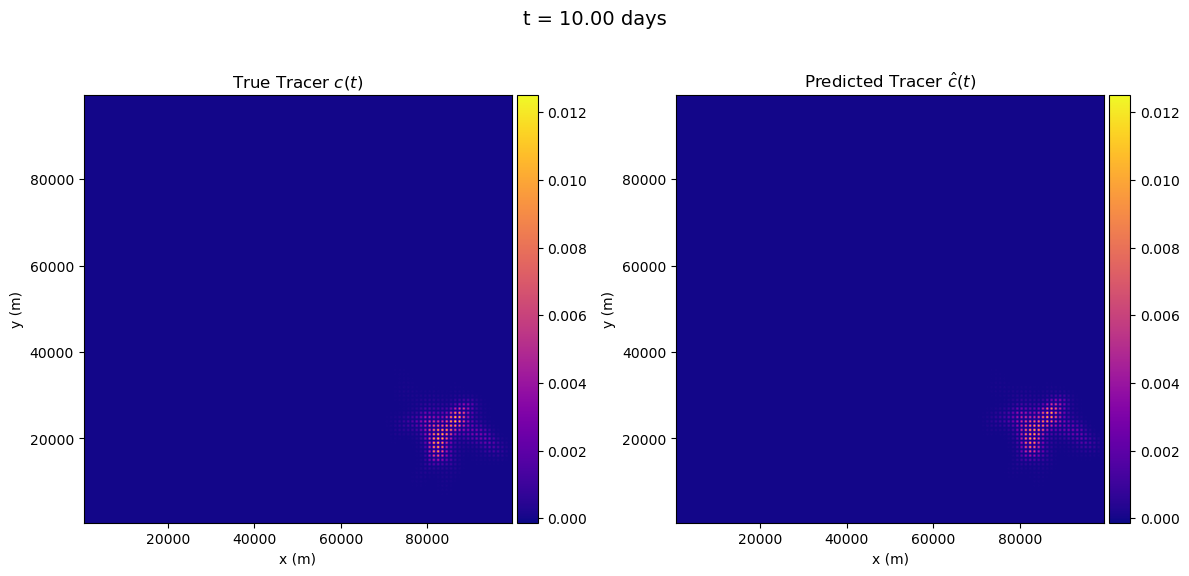

In [20]:
#Let the model predict multiple future steps using its own output as input (ACE-style)

# --- Setup prediction and unnormalize ---
t_index = 240
n_future = 480

model.eval()
with torch.no_grad():
    f_seq = forcing_tensor[t_index : t_index + n_future]
    p0 = prognostic_tensor[t_index : t_index + 1]
    pred_seq = model(f_seq, p0, training=False, num_future_steps=n_future)

true_seq = target_tensor[t_index : t_index + n_future] * p_std + p_mean
pred_seq = pred_seq * p_std + p_mean

# --- Get coordinates ---
x = ds["xC"].values
y = ds["yC"].values
time_seconds = ds["time"].values.astype("timedelta64[s]").astype(float)
time_days = time_seconds / (24 * 3600)

# --- Plot setup ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
div1 = make_axes_locatable(ax1)
div2 = make_axes_locatable(ax2)
cax1 = div1.append_axes("right", size="5%", pad=0.05)
cax2 = div2.append_axes("right", size="5%", pad=0.05)

im1 = ax1.imshow(true_seq[0].squeeze().cpu(), origin="lower",
                 extent=[x.min(), x.max(), y.min(), y.max()],
                 cmap="plasma")
im2 = ax2.imshow(pred_seq[0].squeeze().cpu(), origin="lower",
                 extent=[x.min(), x.max(), y.min(), y.max()],
                 cmap="plasma")

fig.colorbar(im1, cax=cax1)
fig.colorbar(im2, cax=cax2)

ax1.set_title("True Tracer $c(t)$")
ax2.set_title("Predicted Tracer $\\hat{c}(t)$")
for ax in (ax1, ax2):
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")

# Time annotation
title = fig.suptitle(f"t = {time_days[t_index]:.2f} days", fontsize=14)

# --- Update function with auto contrast ---
def update(frame):
    c_true = true_seq[frame].squeeze().cpu()
    c_pred = pred_seq[frame].squeeze().cpu()

    im1.set_array(c_true)
    im2.set_array(c_pred)

    # Match dynamic range per frame
    cmin = min(c_true.min().item(), c_pred.min().item())
    cmax = max(c_true.max().item(), c_pred.max().item(), 1e-3)  # avoid zero range

    im1.set_clim(vmin=cmin, vmax=cmax)
    im2.set_clim(vmin=cmin, vmax=cmax)

    title.set_text(f"t = {time_days[t_index + frame]:.2f} days")
    return [im1, im2, title]

# --- Animate and save ---
ani = FuncAnimation(fig, update, frames=n_future, interval=100, blit=False)
plt.tight_layout()
ani.save("tracer_truth_vs_pred2.gif", writer="pillow", fps=10)
Image(filename="tracer_truth_vs_pred2.gif")